In [1]:
# 1. Setup and Configuration
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from torchvision.models.feature_extraction import create_feature_extractor
from PIL import Image
import os
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
import tempfile
import shutil
import zipfile
import requests
import matplotlib.pyplot as plt

torch.set_num_threads(max(1, os.cpu_count() - 1))
torch.set_num_interop_threads(2)
torch.backends.mkldnn.enabled = True

# For BLEU evaluation
try:
    from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
except ImportError:
    print("NLTK not found. Installing...")
    import subprocess
    subprocess.check_call(["pip", "install", "nltk"])
    from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# Download NLTK data if not already present
print("Setting up NLTK resources...")
try:
    # Test if tokenization works
    from nltk.tokenize import word_tokenize
    word_tokenize("test")
    print("NLTK tokenization ready")
except Exception as e:
    print(f"NLTK setup needed: {e}")
    try:
        print("Downloading punkt...")
        nltk.download('punkt', quiet=True)
        print("Downloading punkt_tab...")
        nltk.download('punkt_tab', quiet=True)
        print("NLTK resources downloaded")
        # Test again
        from nltk.tokenize import word_tokenize
        word_tokenize("test")
        print("NLTK tokenization now working")
    except Exception as download_error:
        print(f"NLTK download failed: {download_error}")
        print("Please run manually: python -m nltk.downloader punkt punkt_tab")

# --- Configuration ---
class Config:
    DATA_DIR = 'flickr8k'
    IMAGES_DIR = os.path.join(DATA_DIR, 'Flicker8k_Dataset')
    CAPTIONS_FILE = os.path.join(DATA_DIR, 'Flickr8k.token.txt')

    CACHED_FEATURES_DIR = 'cached_features'

    EMBED_SIZE = 512
    HIDDEN_SIZE = 512
    NUM_LAYERS = 1
    VOCAB_THRESHOLD = 5

    BATCH_SIZE = 64
    NUM_EPOCHS = 20

    LEARNING_RATE = 1e-4
    LOG_STEP = 1200
    SAVE_STEP = 1
    DROPOUT_PROB = 0.3

    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    INTEGRATION_STRATEGY = 'hidden_state_init'

print(f"Using device: {Config.DEVICE}")

# Create directories if they don't exist
os.makedirs('models', exist_ok=True)
os.makedirs('outputs', exist_ok=True)
os.makedirs('results', exist_ok=True)
os.makedirs(Config.CACHED_FEATURES_DIR, exist_ok=True)

# Set device and other variables from Config
device = Config.DEVICE
embed_dim = Config.EMBED_SIZE
decoder_dim = Config.HIDDEN_SIZE
dropout = Config.DROPOUT_PROB
epochs = Config.NUM_EPOCHS
batch_size = Config.BATCH_SIZE
learning_rate = Config.LEARNING_RATE
fine_tune_encoder = True
decoder_lr = learning_rate
encoder_lr = learning_rate * 0.1 

Setting up NLTK resources...
NLTK tokenization ready
Using device: cpu


In [2]:
class Vocabulary:
    def __init__(self, threshold):
        self.threshold = threshold
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

        self.add_word('<pad>')
        self.add_word('<start>')
        self.add_word('<end>')
        self.add_word('<unk>')

    def add_word(self, word):
        if word not in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def build_vocabulary(self, captions_list):
        counter = Counter()
        for caption in tqdm(captions_list, desc="Building Vocabulary"):
            tokens = word_tokenize(caption.lower())
            counter.update(tokens)

        words = [word for word, count in counter.items() if count >= self.threshold]
        for word in words:
            self.add_word(word)

        print(f"Vocabulary built with {len(self.word2idx)} unique words (threshold={self.threshold}).")

    def __call__(self, word):
        if word not in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

In [3]:
class Flickr8kDataset(Dataset):
    def __init__(self, captions_file, images_dir, vocab, transform, cached_features_dir, feature_extractor_model=None):
        self.captions_file = captions_file
        self.images_dir = images_dir
        self.vocab = vocab
        self.transform = transform
        self.cached_features_dir = cached_features_dir

        self.feature_extractor_model = feature_extractor_model
        if self.feature_extractor_model:
            self.feature_extractor_model.to(Config.DEVICE)
            self.feature_extractor_model.eval()

        self.annotations = self._parse_captions()
        self.image_ids = list(self.annotations.keys())

        if not self.image_ids:
            raise ValueError(
                "No image IDs found after parsing captions file. "
                "Please check if 'Flickr8k.token.txt' is correctly formatted "
                "and contains valid image-caption entries."
            )

        print("Checking and caching image features...")
        self._cache_features()

    def _parse_captions(self):
        annotations = {}
        parsed_lines_count = 0
        skipped_lines_count = 0
        with open(self.captions_file, 'r') as f:
            for line_num, line in enumerate(f, 1):
                line = line.strip()
                if not line:
                    skipped_lines_count += 1
                    continue

                # Format: image_id.jpg#caption_number caption text
                parts = line.split('\t', 1)
                if len(parts) < 2:
                    # Try space split if tab doesn't work
                    parts = line.split(' ', 1)
                    if len(parts) < 2:
                        print(f"Warning: Skipping malformed line {line_num} in captions file: '{line}' (Expected format: 'image.jpg#N caption text').")
                        skipped_lines_count += 1
                        continue

                image_caption_id = parts[0].strip()
                caption_text = parts[1].strip()

                # Extract image ID from image_id.jpg#caption_number or image_id.jpg.caption_number
                if '#' in image_caption_id:
                    image_id = image_caption_id.split('#')[0]
                elif '.jpg.' in image_caption_id:
                    # Handle format like "image.jpg.1"
                    image_id = image_caption_id.split('.jpg.')[0] + '.jpg'
                else:
                    image_id = image_caption_id

                if not image_id.lower().endswith('.jpg'):
                    print(f"Warning: Skipping malformed image ID format on line {line_num}: '{image_id}' (Expected format like 'image.jpg').")
                    skipped_lines_count += 1
                    continue

                if image_id not in annotations:
                    annotations[image_id] = []
                annotations[image_id].append(caption_text)
                parsed_lines_count += 1

        print(f"Finished parsing captions. Successfully parsed {parsed_lines_count} lines. Skipped {skipped_lines_count} lines.")
        if not annotations:
            print("Critical Warning: No valid image-caption entries were parsed from the captions file.")
        return annotations

    def _cache_features(self):
        if self.feature_extractor_model is None:
            print("Feature extractor model not provided; assuming features are already cached.")
            verified_image_ids = []
            for img_id in tqdm(list(self.annotations.keys()), desc="Verifying cached features"):
                cache_path = os.path.join(self.cached_features_dir, img_id.replace('.jpg', '.pt'))
                if os.path.exists(cache_path):
                    try:
                        feature = torch.load(cache_path)
                        if feature.shape == torch.Size([2048]):
                            verified_image_ids.append(img_id)
                        else:
                            print(f"Warning: Cached feature for {img_id} at {cache_path} has incorrect shape {feature.shape}. Expected torch.Size([2048]). This file will be marked for re-caching if a feature extractor is provided later.")
                    except Exception as e:
                        print(f"Warning: Could not load cached feature for {img_id} at {cache_path}: {e}. This file will be marked for re-caching if a feature extractor is provided later.")
                else:
                    print(f"Warning: Cached feature file not found for {img_id} at {cache_path}. This image will be skipped if no feature extractor is provided.")

            if len(verified_image_ids) < len(self.annotations.keys()):
                print(f"Warning: {len(self.annotations.keys()) - len(verified_image_ids)} images had missing or problematic cached features. These will be excluded from the dataset.")
            self.image_ids = verified_image_ids
            return

        initial_image_ids = list(self.annotations.keys())

        self.feature_extractor_model.eval()
        self.feature_extractor_model.to(Config.DEVICE)

        problematic_images = set()

        for img_id in tqdm(initial_image_ids, desc="Caching features"):
            img_path = os.path.join(self.images_dir, img_id)
            cache_path = os.path.join(self.cached_features_dir, img_id.replace('.jpg', '.pt'))

            if os.path.exists(cache_path):
                try:
                    existing_feature = torch.load(cache_path)
                    if existing_feature.shape == torch.Size([2048]):
                        continue
                    else:
                        print(f"Warning: Existing cached feature for {img_id} at {cache_path} has incorrect shape {existing_feature.shape}. Re-caching.")
                        os.remove(cache_path)
                except Exception as e:
                    print(f"Warning: Could not load existing cached feature for {img_id} at {cache_path}: {e}. Re-caching.")
                    if os.path.exists(cache_path):
                        os.remove(cache_path)

            try:
                if not os.path.exists(img_path):
                    print(f"Warning: Image file not found for {img_id} at {img_path}. Skipping feature caching for this image.")
                    problematic_images.add(img_id)
                    continue

                image = Image.open(img_path).convert('RGB')
                image = self.transform(image).unsqueeze(0).to(Config.DEVICE)

                with torch.no_grad():
                    features = self.feature_extractor_model(image).squeeze(0)

                if features.shape != torch.Size([2048]):
                    print(f"Warning: Feature extraction for {img_id} resulted in unexpected shape {features.shape}. Expected torch.Size([2048]). This feature will NOT be cached.")
                    problematic_images.add(img_id)
                    continue

                torch.save(features.cpu(), cache_path)
            except Exception as e:
                print(f"Error processing image {img_id} during feature caching: {e}")
                problematic_images.add(img_id)
                continue

        print("Feature caching complete.")

        if problematic_images:
            self.image_ids = [img_id for img_id in initial_image_ids if img_id not in problematic_images]
            print(f"Warning: Skipped caching features for {len(problematic_images)} images due to errors or unexpected shapes. These images will be excluded from the dataset.")
            for img_id in list(problematic_images)[:5]:
                print(f"- {img_id}")
            if len(problematic_images) > 5:
                print(f"... and {len(problematic_images) - 5} more.")
            print(f"Adjusted dataset size to {len(self.image_ids) * 5} (from {len(initial_image_ids) * 5}) after filtering problematic images.")
        else:
            self.image_ids = initial_image_ids
            print("All image features cached successfully with correct shapes.")


    def __len__(self):
        return len(self.image_ids) * 5

    def __getitem__(self, idx):
        img_idx = idx // 5
        cap_idx = idx % 5

        img_id = self.image_ids[img_idx]
        caption_text = self.annotations[img_id][cap_idx]

        feature_path = os.path.join(self.cached_features_dir, img_id.replace('.jpg', '.pt'))

        try:
            image_feature = torch.load(feature_path)
            if image_feature.shape != torch.Size([2048]):
                raise RuntimeError(f"CRITICAL: Loaded feature for {img_id} from {feature_path} has incorrect shape: {image_feature.shape}. Expected torch.Size([2048]). This indicates a corruption *after* caching or a logic error in filtering.")
        except Exception as e:
            print(f"Error loading cached feature for {img_id} at {feature_path}: {e}. Returning a zero tensor as fallback.")
            image_feature = torch.zeros(2048)

        tokens = word_tokenize(caption_text.lower())
        caption_sequence = [self.vocab('<start>')] + [self.vocab(token) for token in tokens] + [self.vocab('<end>')]

        return image_feature, torch.tensor(caption_sequence)

def collate_fn(data):
    data.sort(key=lambda x: len(x[1]), reverse=True)
    images, captions = zip(*data)

    images = torch.stack(images, 0)

    lengths = [len(cap) for cap in captions]
    targets = torch.zeros(len(captions), max(lengths)).long()
    for i, cap in enumerate(captions):
        end = lengths[i]
        targets[i, :end] = cap[:end]

    return images, targets, lengths

In [4]:
class ImageFiles(Dataset):
    def __init__(self, image_ids, images_dir, transform):
        self.ids = image_ids
        self.root = images_dir
        self.tf = transform
    def __len__(self): return len(self.ids)
    def __getitem__(self, i):
        p = os.path.join(self.root, self.ids[i])
        img = Image.open(p).convert('RGB')
        return self.tf(img), self.ids[i]

def cache_features_cpu(image_ids, images_dir, transform, encoder, out_dir, batch_size=64, num_workers=0):
    os.makedirs(out_dir, exist_ok=True)
    # skip those already cached
    ids_to_do = [i for i in image_ids if not os.path.exists(os.path.join(out_dir, i.replace('.jpg', '.pt')))]
    if not ids_to_do:
        print("All features already cached."); return

    ds = ImageFiles(ids_to_do, images_dir, transform)
    dl = DataLoader(ds, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=False)

    encoder.eval()
    with torch.inference_mode():
        for imgs, ids in tqdm(dl, desc="Caching features (CPU, batched)"):
            feats = encoder(imgs)  # (B, 2048) from your EncoderCNN
            feats = feats.cpu()
            for f, img_id in zip(feats, ids):
                torch.save(f, os.path.join(out_dir, img_id.replace('.jpg', '.pt')))

In [ ]:
class EncoderCNN(nn.Module):
    def __init__(self):
        super(EncoderCNN, self).__init__()
        print("Downloading ResNet-50 weights (first time only)...")
        resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        print("Weights ready.")
        
        self.model = create_feature_extractor(resnet, return_nodes={'layer4': 'feature_map'})

        for param in self.model.parameters():
            param.requires_grad = False

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, images):
        features = self.model(images)['feature_map']
        features = self.avgpool(features)
        features = features.view(features.size(0), -1)
        return features

In [6]:
class DecoderWithGRU(nn.Module):
    def __init__(self, embed_dim, decoder_dim, vocab_size, encoder_dim=2048, dropout=0.5):
        super(DecoderWithGRU, self).__init__()

        self.encoder_dim = encoder_dim
        self.embed_dim = embed_dim
        self.decoder_dim = decoder_dim
        self.vocab_size = vocab_size
        self.dropout = dropout

        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.dropout_layer = nn.Dropout(p=self.dropout)
        self.init_h = nn.Linear(encoder_dim, decoder_dim)
        self.gru = nn.GRU(embed_dim, decoder_dim, batch_first=True)
        self.fc = nn.Linear(decoder_dim, vocab_size)
        self.init_weights()

    def init_weights(self):
        self.embedding.weight.data.uniform_(-0.1, 0.1)
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-0.1, 0.1)

    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)
        return h.unsqueeze(0)  # (1, batch, decoder_dim) for GRU

    def step(self, word_idx, h):
        """
        word_idx: (B,) LongTensor of token ids
        h: (1,B,H) hidden
        returns logits (B,V), new_h (1,B,H)
        """
        emb = self.embedding(word_idx).unsqueeze(1)          # (B,1,E)
        out, h_new = self.gru(emb, h)                        # out: (B,1,H)
        logits = self.fc(out.squeeze(1))                     # (B,V)
        return logits, h_new

    def forward(self, encoder_out, encoded_captions, caption_lengths):
        batch_size = encoder_out.size(0)
        encoder_dim = encoder_out.size(-1)
        vocab_size = self.vocab_size

        # Flatten image - handle different input shapes safely
        if encoder_out.dim() == 2:  # Already flattened (batch, features)
            encoder_out = encoder_out.unsqueeze(1)  # (batch, 1, features)
        elif encoder_out.dim() == 4:  # Standard CNN output (batch, H, W, channels)
            encoder_out = encoder_out.view(batch_size, -1, encoder_dim)
        else:  # Already correct shape
            pass

        # Sort input data by decreasing lengths
        if caption_lengths.dim() > 1:
            caption_lengths = caption_lengths.squeeze(1)
        caption_lengths, sort_ind = caption_lengths.sort(dim=0, descending=True)
        encoder_out = encoder_out[sort_ind]
        encoded_captions = encoded_captions[sort_ind]

        # Embedding
        embeddings = self.embedding(encoded_captions)
        embeddings = self.dropout_layer(embeddings)

        # Pack the sequences for efficient processing
        packed_embeddings = nn.utils.rnn.pack_padded_sequence(embeddings, (caption_lengths).cpu(), batch_first=True)

        # Initialize GRU state
        h = self.init_hidden_state(encoder_out)  # (1, batch, decoder_dim)

        # Forward through GRU
        packed_outputs, _ = self.gru(packed_embeddings, h)
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs, batch_first=True)

        # Predict vocab for each time step
        predictions = self.fc(outputs)

        # We won't decode at the <end> position
        decode_lengths = (caption_lengths - 1).tolist()

        return predictions, encoded_captions, decode_lengths, sort_ind



In [7]:
def beam_search(decoder, img_feature, vocab, beam_size=5, max_len=20):
    k = beam_size
    start = vocab.word2idx['<start>']
    end   = vocab.word2idx['<end>']

    # init hidden
    encoder_out = img_feature.unsqueeze(1)            # (1,1,2048)
    h = decoder.init_hidden_state(encoder_out)        # (1,1,H)

    beams = [([], h, 0.0)]                            # (seq, h, logprob)
    for _ in range(max_len):
        cand = []
        for seq, h_cur, score in beams:
            if seq and seq[-1] == end:
                cand.append((seq, h_cur, score)); continue

            last = torch.tensor([seq[-1] if seq else start], dtype=torch.long, device=img_feature.device)
            logits, h_next = decoder.step(last, h_cur)     # ✅ use indices
            logp = torch.log_softmax(logits, dim=-1)       # (1,V)
            topk_logp, topk_idx = torch.topk(logp, k, dim=-1)

            for i in range(k):
                cand.append((seq + [topk_idx[0, i].item()], h_next, score + topk_logp[0, i].item()))
        beams = sorted(cand, key=lambda x: x[2], reverse=True)[:k]
        if all(s and s[-1] == end for s,_,_ in beams): break

    return beams[0][0]


### 8. Evaluation (BLEU Score)

These functions provide a way to evaluate the model's performance on a subset of the dataset using BLEU scores, a common metric for machine translation and text generation.


In [8]:
def evaluate_bleu_features(decoder, val_dataset, vocab, beam_size=5, max_len=20, device="cpu"):
    from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
    sf = SmoothingFunction()

    decoder.eval()
    bleu_scores = []
    with torch.no_grad():
        for img_id in val_dataset.image_ids:
            # load cached feature (2048,)
            feat_path = os.path.join(val_dataset.cached_features_dir, img_id.replace(".jpg", ".pt"))
            feat = torch.load(feat_path, map_location=device).unsqueeze(0).to(device) 

            # decode with beam search (must use decoder.step(word_idx, h))
            seq = beam_search(decoder, feat, vocab, beam_size=beam_size, max_len=max_len)

            pred_words = [
                vocab.idx2word[i] for i in seq
                if i not in {vocab.word2idx['<start>'], vocab.word2idx['<end>'], vocab.word2idx['<pad>']}
            ]
            refs = [word_tokenize(c.lower()) for c in val_dataset.annotations[img_id]]

            bleu_scores.append(sentence_bleu(refs, pred_words, smoothing_function=sf.method4))

    avg_bleu = float(np.mean(bleu_scores)) if bleu_scores else 0.0
    return {
        "bleu_overall": avg_bleu,
        "total_images": len(val_dataset.image_ids),
    }


In [9]:
def train_epoch(train_loader, encoder, decoder, criterion, encoder_optimizer, decoder_optimizer):
    encoder.train()
    decoder.train()
    total_loss = 0

    for imgs, caps, caplens in tqdm(train_loader, desc="Training"):
        imgs, caps, caplens = imgs.to(device), caps.to(device), torch.tensor(caplens).to(device)

        # Forward pass
        scores, caps_sorted, decode_lengths, sort_ind = decoder(imgs, caps, caplens)
        targets = caps_sorted[:, 1:]

        # Calculate loss without packing (simpler for GRUCell decoder)
        loss = 0
        for i, length in enumerate(decode_lengths):
            loss += criterion(scores[i, :length, :], targets[i, :length])
        loss /= len(decode_lengths)

        # Backward pass
        decoder_optimizer.zero_grad()
        if encoder_optimizer:
            encoder_optimizer.zero_grad()
        loss.backward()

        # Clip gradients and update
        torch.nn.utils.clip_grad_norm_(decoder.parameters(), 5.0)
        if encoder_optimizer:
            torch.nn.utils.clip_grad_norm_(encoder.parameters(), 5.0)

        decoder_optimizer.step()
        if encoder_optimizer:
            encoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(train_loader)

def validate(val_loader, encoder, decoder, criterion):
    encoder.eval()
    decoder.eval()
    total_loss = 0

    with torch.no_grad():
        for imgs, caps, caplens, _ in tqdm(val_loader, desc="Validation"):
            imgs, caps, caplens = imgs.to(device), caps.to(device), torch.tensor(caplens).to(device)

            scores, caps_sorted, decode_lengths, _ = decoder(imgs, caps, caplens)
            targets = caps_sorted[:, 1:]

            # Calculate loss
            loss = 0
            for i, length in enumerate(decode_lengths):
                loss += criterion(scores[i, :length, :], targets[i, :length])
            loss /= len(decode_lengths)

            total_loss += loss.item()

    return total_loss / len(val_loader)

print("Functions ready")


Functions ready


In [10]:
def load_trained_model(model_path, word_map):
    """Load a trained GRU model from checkpoint"""
    print(f"Loading model from: {model_path}")

    # Initialize fresh models
    encoder_eval = EncoderCNN().to(device)
    decoder_eval = DecoderWithGRU(
        embed_dim=embed_dim,
        decoder_dim=decoder_dim,
        vocab_size=len(word_map),
        dropout=dropout
    ).to(device)

    # Load checkpoint
    checkpoint = torch.load(model_path, map_location=device)
    encoder_eval.load_state_dict(checkpoint['encoder'])
    decoder_eval.load_state_dict(checkpoint['decoder'])

    encoder_eval.eval()
    decoder_eval.eval()

    print("Model loaded successfully!")
    return encoder_eval, decoder_eval

print("Model loading function ready!")


Model loading function ready!


In [11]:
def prepare_data(fast=True):
    print("Preparing data...")

    # 0) Reuse local data if present; otherwise download once
    if not os.path.isdir(Config.DATA_DIR):
        os.makedirs(Config.DATA_DIR, exist_ok=True)
        # download only if missing
        caps_zip = os.path.join(Config.DATA_DIR, "Flickr8k_text.zip")
        imgs_zip = os.path.join(Config.DATA_DIR, "Flickr8k_Dataset.zip")

        if not os.path.exists(caps_zip):
            url = "https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip"
            with requests.get(url, stream=True, timeout=120) as r:
                r.raise_for_status()
                with open(caps_zip, "wb") as f: 
                    for chunk in r.iter_content(8192): f.write(chunk)
        if not os.path.exists(imgs_zip):
            url = "https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip"
            with requests.get(url, stream=True, timeout=300) as r:
                r.raise_for_status()
                with open(imgs_zip, "wb") as f: 
                    for chunk in r.iter_content(8192): f.write(chunk)

        # unzip into Config.DATA_DIR
        with zipfile.ZipFile(caps_zip, 'r') as z: z.extractall(Config.DATA_DIR)
        with zipfile.ZipFile(imgs_zip, 'r') as z: z.extractall(Config.DATA_DIR)

    captions_file = Config.CAPTIONS_FILE
    images_dir    = Config.IMAGES_DIR
    features_dir  = Config.CACHED_FEATURES_DIR
    os.makedirs(features_dir, exist_ok=True)

    # 1) Build vocab
    all_captions = []
    with open(captions_file, 'r') as f:
        for line in f:
            parts = line.strip().split('\t', 1)
            if len(parts) < 2:
                parts = line.strip().split(' ', 1)
                if len(parts) < 2: continue
            all_captions.append(parts[1].strip())

    vocab = Vocabulary(Config.VOCAB_THRESHOLD)
    vocab.build_vocabulary(all_captions)
    print(f"Vocabulary size: {len(vocab)}")

    # 2) Parse captions → image_ids
    annotations = {}
    with open(captions_file, 'r') as f:
        for line in f:
            line = line.strip()
            if not line: continue
            k, cap = line.split('\t', 1) if '\t' in line else line.split(' ', 1)
            img_id = k.split('#')[0] if '#' in k else (k.split('.jpg.')[0] + '.jpg' if '.jpg.' in k else k)
            if not img_id.lower().endswith('.jpg'): continue
            annotations.setdefault(img_id, []).append(cap.strip())
    all_ids = list(annotations.keys())

    # 3) Use official splits to avoid caching all 8k images
    train_list = os.path.join(Config.DATA_DIR, "Flickr_8k.trainImages.txt")
    dev_list   = os.path.join(Config.DATA_DIR, "Flickr_8k.devImages.txt")
    if os.path.exists(train_list) and os.path.exists(dev_list):
        def read_ids(p): 
            with open(p) as f: return [l.strip() for l in f if l.strip()]
        train_ids = read_ids(train_list)
        val_ids   = read_ids(dev_list)
    else:
        # fallback: random split
        from sklearn.model_selection import train_test_split
        train_ids, val_ids = train_test_split(all_ids, test_size=0.1, random_state=42)

    # 4) Transform + (fast) CPU feature caching only for train+val
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    if fast:
        temp_encoder = EncoderCNN()  # runs on CPU
        ids_to_cache = list(set(train_ids + val_ids))
        cache_features_cpu(ids_to_cache, images_dir, transform, temp_encoder, features_dir,
                           batch_size=64, num_workers=0)
        del temp_encoder

    # 5) Build minimal dataset objects that read cached features only
    def make_dataset(ids):
        ds = Flickr8kDataset(
            captions_file, images_dir, vocab, transform, features_dir, feature_extractor_model=None
        )
        ds.image_ids = ids
        ds.annotations = {img_id: annotations[img_id] for img_id in ids}
        return ds

    train_dataset = make_dataset(train_ids)
    val_dataset   = make_dataset(val_ids)

    train_loader = DataLoader(train_dataset, batch_size=Config.BATCH_SIZE, shuffle=True,
                              num_workers=0, collate_fn=collate_fn, pin_memory=False)
    val_loader   = DataLoader(val_dataset, batch_size=Config.BATCH_SIZE, shuffle=False,
                              num_workers=0, collate_fn=collate_fn, pin_memory=False)

    decoder = DecoderWithGRU(Config.EMBED_SIZE, Config.HIDDEN_SIZE, len(vocab),
                             dropout=Config.DROPOUT_PROB).to(Config.DEVICE)
    criterion = nn.CrossEntropyLoss(ignore_index=vocab('<pad>'))
    optimizer = optim.Adam(decoder.parameters(), lr=Config.LEARNING_RATE)

    print("Data prep complete.")
    return decoder, vocab, val_dataset, train_loader, val_loader, criterion, optimizer


In [12]:
# Prepare data and get training components
decoder, vocab, val_dataset, train_loader, val_loader, criterion, decoder_optimizer, temp_dir = prepare_data()

Preparing data...


Building Vocabulary: 100%|██████████| 40460/40460 [00:23<00:00, 1752.42it/s]


Vocabulary built with 3005 unique words (threshold=5).
Vocabulary size: 3005
Weights ready.


Caching features (CPU, batched): 100%|██████████| 110/110 [38:28<00:00, 20.99s/it]


Finished parsing captions. Successfully parsed 40455 lines. Skipped 5 lines.
Checking and caching image features...
Feature extractor model not provided; assuming features are already cached.


Verifying cached features:   1%|          | 44/8091 [00:05<24:11,  5.54it/s]

Verifying cached features:   1%|          | 51/8091 [00:06<14:50,  9.02it/s]

Verifying cached features:   1%|          | 67/8091 [00:07<09:51, 13.57it/s]

Verifying cached features:   1%|          | 90/8091 [00:09<09:06, 14.63it/s]

Verifying cached features:   1%|          | 100/8091 [00:10<10:37, 12.53it/s]

Verifying cached features:   1%|▏         | 114/8091 [00:11<08:09, 16.29it/s]

Verifying cached features:   1%|▏         | 121/8091 [00:11<06:30, 20.40it/s]

Verifying cached features:   2%|▏         | 126/8091 [00:11<07:42, 17.21it/s]

Verifying cached features:   2%|▏         | 130/8091 [00:12<07:28, 17.74it/s]

Verifying cached features:   2%|▏         | 146/8091 [00:13<08:37, 15.35it/s]

Verifying cached features:   2%|▏         | 155/8091 [00:14<09:42, 13.61it/s]

Verifying cached features:   2%|▏         | 159/8091 [00:14<08:46, 15.08it/s]

Verifying cached features:   2%|▏         | 182/8091 [00:16<10:55, 12.07it/s]

Verifying cached features:   2%|▏         | 197/8091 [00:17<11:38, 11.30it/s]

Verifying cached features:   3%|▎         | 210/8091 [00:19<11:37, 11.30it/s]

Verifying cached features:   3%|▎         | 220/8091 [00:22<43:31,  3.01it/s]  

Verifying cached features:   3%|▎         | 226/8091 [00:23<20:34,  6.37it/s]

Verifying cached features:   3%|▎         | 228/8091 [00:23<16:19,  8.03it/s]

Verifying cached features:   3%|▎         | 236/8091 [00:24<11:17, 11.59it/s]

Verifying cached features:   3%|▎         | 240/8091 [00:24<10:29, 12.46it/s]

Verifying cached features:   3%|▎         | 248/8091 [00:24<08:57, 14.59it/s]

Verifying cached features:   3%|▎         | 262/8091 [00:26<11:03, 11.81it/s]

Verifying cached features:   3%|▎         | 282/8091 [00:28<10:38, 12.23it/s]

Verifying cached features:   4%|▎         | 291/8091 [00:28<10:21, 12.55it/s]

Verifying cached features:   4%|▎         | 295/8091 [00:29<10:19, 12.58it/s]

Verifying cached features:   4%|▎         | 303/8091 [00:29<09:03, 14.33it/s]

Verifying cached features:   4%|▍         | 313/8091 [00:30<11:18, 11.46it/s]

Verifying cached features:   4%|▍         | 315/8091 [00:30<10:24, 12.46it/s]

Verifying cached features:   4%|▍         | 322/8091 [00:31<11:11, 11.57it/s]

Verifying cached features:   4%|▍         | 333/8091 [00:32<10:04, 12.83it/s]

Verifying cached features:   4%|▍         | 342/8091 [00:33<09:43, 13.27it/s]

Verifying cached features:   4%|▍         | 354/8091 [00:34<08:34, 15.05it/s]

Verifying cached features:   4%|▍         | 358/8091 [00:34<08:56, 14.42it/s]

Verifying cached features:   5%|▍         | 368/8091 [00:35<09:58, 12.90it/s]

Verifying cached features:   5%|▍         | 373/8091 [00:35<08:35, 14.96it/s]

Verifying cached features:   5%|▍         | 377/8091 [00:35<08:45, 14.69it/s]

Verifying cached features:   5%|▍         | 382/8091 [00:36<07:51, 16.34it/s]

Verifying cached features:   5%|▍         | 397/8091 [00:37<09:59, 12.84it/s]

Verifying cached features:   5%|▍         | 404/8091 [00:38<09:51, 13.01it/s]

Verifying cached features:   5%|▌         | 408/8091 [00:38<09:24, 13.61it/s]

Verifying cached features:   5%|▌         | 418/8091 [00:39<09:04, 14.10it/s]

Verifying cached features:   5%|▌         | 437/8091 [00:41<13:10,  9.69it/s]

Verifying cached features:   5%|▌         | 442/8091 [00:42<14:10,  9.00it/s]

Verifying cached features:   6%|▌         | 451/8091 [00:43<12:44, 10.00it/s]

Verifying cached features:   6%|▌         | 455/8091 [00:43<12:11, 10.44it/s]

Verifying cached features:   6%|▌         | 467/8091 [00:45<15:19,  8.29it/s]

Verifying cached features:   6%|▌         | 475/8091 [00:46<11:49, 10.73it/s]

Verifying cached features:   6%|▌         | 485/8091 [00:47<11:09, 11.36it/s]

Verifying cached features:   6%|▌         | 497/8091 [00:48<10:08, 12.48it/s]

Verifying cached features:   6%|▋         | 510/8091 [00:49<09:11, 13.73it/s]

Verifying cached features:   6%|▋         | 521/8091 [00:52<18:37,  6.77it/s]

Verifying cached features:   7%|▋         | 538/8091 [00:54<11:10, 11.26it/s]

Verifying cached features:   7%|▋         | 546/8091 [00:54<09:08, 13.75it/s]

Verifying cached features:   7%|▋         | 550/8091 [00:55<10:21, 12.13it/s]

Verifying cached features:   7%|▋         | 555/8091 [00:55<10:26, 12.02it/s]

Verifying cached features:   7%|▋         | 559/8091 [00:55<09:50, 12.76it/s]

Verifying cached features:   7%|▋         | 569/8091 [00:56<10:18, 12.17it/s]

Verifying cached features:   7%|▋         | 576/8091 [00:57<10:19, 12.14it/s]

Verifying cached features:   7%|▋         | 585/8091 [00:58<09:56, 12.59it/s]

Verifying cached features:   7%|▋         | 591/8091 [00:58<08:59, 13.90it/s]

Verifying cached features:   7%|▋         | 595/8091 [00:58<09:35, 13.02it/s]

Verifying cached features:   7%|▋         | 597/8091 [00:58<08:42, 14.34it/s]

Verifying cached features:   8%|▊         | 612/8091 [01:00<09:34, 13.03it/s]

Verifying cached features:   8%|▊         | 623/8091 [01:01<09:38, 12.90it/s]

Verifying cached features:   8%|▊         | 634/8091 [01:02<09:45, 12.74it/s]

Verifying cached features:   8%|▊         | 644/8091 [01:02<08:33, 14.50it/s]

Verifying cached features:   8%|▊         | 649/8091 [01:03<08:10, 15.16it/s]

Verifying cached features:   8%|▊         | 656/8091 [01:03<08:01, 15.45it/s]

Verifying cached features:   8%|▊         | 659/8091 [01:03<07:35, 16.31it/s]

Verifying cached features:   8%|▊         | 664/8091 [01:06<26:38,  4.65it/s]

Verifying cached features:   8%|▊         | 674/8091 [01:06<12:09, 10.17it/s]

Verifying cached features:   8%|▊         | 684/8091 [01:07<08:11, 15.08it/s]

Verifying cached features:   9%|▊         | 696/8091 [01:08<07:16, 16.95it/s]

Verifying cached features:   9%|▊         | 702/8091 [01:08<06:56, 17.74it/s]

Verifying cached features:   9%|▉         | 709/8091 [01:08<07:48, 15.76it/s]

Verifying cached features:   9%|▉         | 716/8091 [01:09<08:29, 14.48it/s]

Verifying cached features:   9%|▉         | 723/8091 [01:09<08:31, 14.41it/s]

Verifying cached features:   9%|▉         | 730/8091 [01:10<08:25, 14.57it/s]

Verifying cached features:   9%|▉         | 736/8091 [01:10<07:20, 16.69it/s]

Verifying cached features:   9%|▉         | 754/8091 [01:12<09:25, 12.99it/s]

Verifying cached features:  10%|▉         | 775/8091 [01:17<10:55, 11.16it/s]

Verifying cached features:  10%|▉         | 782/8091 [01:18<11:31, 10.58it/s]

Verifying cached features:  10%|▉         | 786/8091 [01:18<12:00, 10.14it/s]

Verifying cached features:  10%|▉         | 809/8091 [01:24<16:31,  7.34it/s]  

Verifying cached features:  10%|█         | 812/8091 [01:24<13:13,  9.17it/s]

Verifying cached features:  10%|█         | 821/8091 [01:25<12:49,  9.44it/s]

Verifying cached features:  10%|█         | 826/8091 [01:26<11:54, 10.16it/s]

Verifying cached features:  10%|█         | 834/8091 [01:26<07:00, 17.25it/s]

Verifying cached features:  10%|█         | 839/8091 [01:27<09:11, 13.16it/s]

Verifying cached features:  11%|█         | 850/8091 [01:28<09:51, 12.24it/s]

Verifying cached features:  11%|█         | 860/8091 [01:28<10:12, 11.81it/s]

Verifying cached features:  11%|█         | 872/8091 [01:30<10:36, 11.33it/s]

Verifying cached features:  11%|█         | 882/8091 [01:31<10:57, 10.96it/s]

Verifying cached features:  11%|█         | 890/8091 [01:31<09:49, 12.21it/s]

Verifying cached features:  11%|█         | 898/8091 [01:32<12:41,  9.44it/s]

Verifying cached features:  11%|█▏        | 918/8091 [01:35<09:43, 12.29it/s]

Verifying cached features:  11%|█▏        | 926/8091 [01:35<06:51, 17.43it/s]

Verifying cached features:  12%|█▏        | 933/8091 [01:36<06:52, 17.37it/s]

Verifying cached features:  12%|█▏        | 946/8091 [01:37<10:23, 11.47it/s]

Verifying cached features:  12%|█▏        | 950/8091 [01:37<11:47, 10.10it/s]

Verifying cached features:  12%|█▏        | 959/8091 [01:38<08:51, 13.41it/s]

Verifying cached features:  12%|█▏        | 971/8091 [01:39<06:43, 17.63it/s]

Verifying cached features:  12%|█▏        | 994/8091 [01:42<14:16,  8.28it/s]

Verifying cached features:  12%|█▏        | 1006/8091 [01:43<09:30, 12.41it/s]

Verifying cached features:  12%|█▏        | 1010/8091 [01:44<09:02, 13.05it/s]

Verifying cached features:  13%|█▎        | 1014/8091 [01:44<09:12, 12.80it/s]

Verifying cached features:  13%|█▎        | 1020/8091 [01:44<09:01, 13.06it/s]

Verifying cached features:  13%|█▎        | 1037/8091 [01:46<08:11, 14.36it/s]

Verifying cached features:  13%|█▎        | 1053/8091 [01:47<07:00, 16.72it/s]

Verifying cached features:  13%|█▎        | 1059/8091 [01:47<05:50, 20.05it/s]

Verifying cached features:  13%|█▎        | 1064/8091 [01:48<08:19, 14.07it/s]

Verifying cached features:  13%|█▎        | 1074/8091 [01:49<11:33, 10.12it/s]

Verifying cached features:  13%|█▎        | 1082/8091 [01:50<10:16, 11.38it/s]

Verifying cached features:  14%|█▎        | 1098/8091 [01:51<06:08, 18.98it/s]

Verifying cached features:  14%|█▎        | 1102/8091 [01:51<06:51, 17.00it/s]

Verifying cached features:  14%|█▎        | 1112/8091 [01:52<10:19, 11.27it/s]

Verifying cached features:  14%|█▍        | 1116/8091 [01:52<09:36, 12.10it/s]

Verifying cached features:  14%|█▍        | 1120/8091 [01:53<09:24, 12.34it/s]

Verifying cached features:  14%|█▍        | 1124/8091 [01:53<09:36, 12.08it/s]

Verifying cached features:  14%|█▍        | 1139/8091 [01:55<14:23,  8.05it/s]

Verifying cached features:  14%|█▍        | 1153/8091 [01:56<06:40, 17.31it/s]

Verifying cached features:  14%|█▍        | 1166/8091 [01:57<05:51, 19.68it/s]

Verifying cached features:  14%|█▍        | 1173/8091 [01:57<07:19, 15.74it/s]

Verifying cached features:  15%|█▍        | 1179/8091 [01:58<09:09, 12.59it/s]

Verifying cached features:  15%|█▍        | 1183/8091 [01:58<07:42, 14.94it/s]

Verifying cached features:  15%|█▍        | 1186/8091 [02:00<11:42,  9.83it/s]


KeyboardInterrupt: 

In [ ]:
# Initialize training variables
train_losses = []
val_losses = []
bleu_scores = []
best_bleu = 0.0
best_bleu_epoch = 0
start_time = time.time()

print(f"Validation image count: {len(val_dataset.image_ids)}")

# Training loop
for epoch in range(epochs):
    # Training
    decoder.train()
    total_loss = 0

    for imgs, caps, caplens in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
        imgs, caps, caplens = imgs.to(device), caps.to(device), torch.tensor(caplens).to(device)

        # Forward pass
        scores, caps_sorted, decode_lengths, sort_ind = decoder(imgs, caps, caplens)
        targets = caps_sorted[:, 1:]

        # Calculate loss
        loss = 0
        for i, length in enumerate(decode_lengths):
            loss += criterion(scores[i, :length, :], targets[i, :length])
        loss /= len(decode_lengths)

        # Backward pass
        decoder_optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(decoder.parameters(), 5.0)
        decoder_optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    decoder.eval()
    total_val_loss = 0

    with torch.no_grad():
        for imgs, caps, caplens in val_loader:
            imgs, caps, caplens = imgs.to(device), caps.to(device), torch.tensor(caplens).to(device)

            scores, caps_sorted, decode_lengths, _ = decoder(imgs, caps, caplens)
            targets = caps_sorted[:, 1:]

            loss = 0
            for i, length in enumerate(decode_lengths):
                loss += criterion(scores[i, :length, :], targets[i, :length])
            loss /= len(decode_lengths)

            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    epoch_time = time.time() - start_time

    # Evaluate BLEU score every epoch
    print(f"Evaluating BLEU at epoch {epoch+1}...")
    res = evaluate_bleu_features(
        decoder=decoder,
        val_dataset=val_dataset,
        vocab=vocab,
        beam_size=5,
        max_len=20,
        device=device,
    )
    avg_bleu = res["bleu_overall"]
    bleu_scores.append(avg_bleu)

    if avg_bleu > best_bleu:
        best_bleu = avg_bleu
        best_bleu_epoch = epoch + 1
        print(f"NEW BEST BLEU! {best_bleu:.4f} @ epoch {best_bleu_epoch}")


    print(f'Epoch [{epoch+1}/{epochs}] - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, BLEU: {avg_bleu:.4f}, Time: {epoch_time:.1f}s')

    # Save checkpoint every 5 epochs
    if (epoch + 1) % 5 == 0:
        checkpoint = {
            'epoch': epoch + 1,
            'decoder': decoder.state_dict(),
            'decoder_optimizer': decoder_optimizer.state_dict(),
            'train_losses': train_losses,
            'val_losses': val_losses,
            'bleu_scores': bleu_scores,
            'best_bleu': best_bleu,
            'best_bleu_epoch': best_bleu_epoch
        }
        torch.save(checkpoint, f'outputs/checkpoint_gru_flickr8k_epoch_{epoch+1}.pth.tar')
        print(f'Checkpoint saved at epoch {epoch+1} (Best BLEU: {best_bleu:.4f} at epoch {best_bleu_epoch})')

print("Training loop completed successfully!")

Validation image count: 810


Training Epoch 1: 100%|██████████| 569/569 [10:11<00:00,  1.07s/it]


Evaluating BLEU score at epoch 1...
NEW BEST BLEU! Score: 0.1497 at epoch 1
Epoch [1/20] - Train Loss: 4.5516, Val Loss: 3.7222, BLEU: 0.1497, Time: 624.3s


Training Epoch 2: 100%|██████████| 569/569 [10:05<00:00,  1.06s/it]


Evaluating BLEU score at epoch 2...
NEW BEST BLEU! Score: 0.1666 at epoch 2
Epoch [2/20] - Train Loss: 3.5563, Val Loss: 3.2979, BLEU: 0.1666, Time: 1322.0s


Training Epoch 3: 100%|██████████| 569/569 [10:01<00:00,  1.06s/it]


Evaluating BLEU score at epoch 3...
NEW BEST BLEU! Score: 0.1834 at epoch 3
Epoch [3/20] - Train Loss: 3.2307, Val Loss: 3.0842, BLEU: 0.1834, Time: 2021.8s


Training Epoch 4: 100%|██████████| 569/569 [10:16<00:00,  1.08s/it]


Evaluating BLEU score at epoch 4...
NEW BEST BLEU! Score: 0.1933 at epoch 4
Epoch [4/20] - Train Loss: 3.0316, Val Loss: 2.9496, BLEU: 0.1933, Time: 2741.6s


Training Epoch 5: 100%|██████████| 569/569 [10:21<00:00,  1.09s/it]


Evaluating BLEU score at epoch 5...
NEW BEST BLEU! Score: 0.2005 at epoch 5
Epoch [5/20] - Train Loss: 2.8911, Val Loss: 2.8589, BLEU: 0.2005, Time: 3456.1s
Checkpoint saved at epoch 5 (Best BLEU: 0.2005 at epoch 5)


Training Epoch 6: 100%|██████████| 569/569 [10:18<00:00,  1.09s/it]


Evaluating BLEU score at epoch 6...
NEW BEST BLEU! Score: 0.2066 at epoch 6
Epoch [6/20] - Train Loss: 2.7813, Val Loss: 2.7944, BLEU: 0.2066, Time: 4169.4s


Training Epoch 7: 100%|██████████| 569/569 [3:14:01<00:00, 20.46s/it]      


Evaluating BLEU score at epoch 7...
NEW BEST BLEU! Score: 0.2162 at epoch 7
Epoch [7/20] - Train Loss: 2.6946, Val Loss: 2.7396, BLEU: 0.2162, Time: 15916.8s


Training Epoch 8: 100%|██████████| 569/569 [11:31<00:00,  1.22s/it]


Evaluating BLEU score at epoch 8...
NEW BEST BLEU! Score: 0.2229 at epoch 8
Epoch [8/20] - Train Loss: 2.6213, Val Loss: 2.7019, BLEU: 0.2229, Time: 16729.9s


Training Epoch 9: 100%|██████████| 569/569 [11:28<00:00,  1.21s/it]


Evaluating BLEU score at epoch 9...
Epoch [9/20] - Train Loss: 2.5549, Val Loss: 2.6671, BLEU: 0.2180, Time: 17530.9s


Training Epoch 10: 100%|██████████| 569/569 [11:41<00:00,  1.23s/it]


Evaluating BLEU score at epoch 10...
Epoch [10/20] - Train Loss: 2.4970, Val Loss: 2.6434, BLEU: 0.2195, Time: 18351.6s
Checkpoint saved at epoch 10 (Best BLEU: 0.2229 at epoch 8)


Training Epoch 11: 100%|██████████| 569/569 [09:27<00:00,  1.00it/s]


Evaluating BLEU score at epoch 11...
NEW BEST BLEU! Score: 0.2230 at epoch 11
Epoch [11/20] - Train Loss: 2.4448, Val Loss: 2.6211, BLEU: 0.2230, Time: 19015.8s


Training Epoch 12: 100%|██████████| 569/569 [09:54<00:00,  1.04s/it]


Evaluating BLEU score at epoch 12...
Epoch [12/20] - Train Loss: 2.3952, Val Loss: 2.6017, BLEU: 0.2222, Time: 19702.5s


Training Epoch 13: 100%|██████████| 569/569 [09:29<00:00,  1.00s/it]


Evaluating BLEU score at epoch 13...
NEW BEST BLEU! Score: 0.2254 at epoch 13
Epoch [13/20] - Train Loss: 2.3518, Val Loss: 2.5842, BLEU: 0.2254, Time: 20364.5s


Training Epoch 14: 100%|██████████| 569/569 [10:12<00:00,  1.08s/it]


Evaluating BLEU score at epoch 14...
Epoch [14/20] - Train Loss: 2.3092, Val Loss: 2.5718, BLEU: 0.2243, Time: 21070.5s


Training Epoch 15: 100%|██████████| 569/569 [09:28<00:00,  1.00it/s]


Evaluating BLEU score at epoch 15...
NEW BEST BLEU! Score: 0.2266 at epoch 15
Epoch [15/20] - Train Loss: 2.2723, Val Loss: 2.5635, BLEU: 0.2266, Time: 21736.4s
Checkpoint saved at epoch 15 (Best BLEU: 0.2266 at epoch 15)


Training Epoch 16: 100%|██████████| 569/569 [09:38<00:00,  1.02s/it]


Evaluating BLEU score at epoch 16...
Epoch [16/20] - Train Loss: 2.2356, Val Loss: 2.5544, BLEU: 0.2262, Time: 22414.7s


Training Epoch 17: 100%|██████████| 569/569 [15:11<00:00,  1.60s/it]


Evaluating BLEU score at epoch 17...
Epoch [17/20] - Train Loss: 2.2023, Val Loss: 2.5497, BLEU: 0.2246, Time: 23437.7s


Training Epoch 18: 100%|██████████| 569/569 [09:15<00:00,  1.02it/s]


Evaluating BLEU score at epoch 18...
Epoch [18/20] - Train Loss: 2.1692, Val Loss: 2.5409, BLEU: 0.2250, Time: 24230.6s


Training Epoch 19: 100%|██████████| 569/569 [12:32<00:00,  1.32s/it]


Evaluating BLEU score at epoch 19...
Epoch [19/20] - Train Loss: 2.1386, Val Loss: 2.5359, BLEU: 0.2240, Time: 25091.2s


Training Epoch 20: 100%|██████████| 569/569 [10:11<00:00,  1.08s/it]


Evaluating BLEU score at epoch 20...
Epoch [20/20] - Train Loss: 2.1091, Val Loss: 2.5347, BLEU: 0.2247, Time: 25805.4s
Checkpoint saved at epoch 20 (Best BLEU: 0.2266 at epoch 15)
Training loop completed successfully!


In [ ]:
# Save results
total_time = time.time() - start_time

# Save final model
torch.save({
    'epoch': len(train_losses),
    'decoder': decoder.state_dict(),
    'decoder_optimizer': decoder_optimizer.state_dict(),
    'train_losses': train_losses,
    'val_losses': val_losses,
    'bleu_scores': bleu_scores,
    'best_bleu': best_bleu,
    'best_bleu_epoch': best_bleu_epoch
}, 'outputs/BEST_checkpoint_gru_flickr8k.pth.tar')

print(f"\nTraining completed in {total_time/60:.1f} minutes!")

# Print peak performance summary
print(f"\nPEAK PERFORMANCE SUMMARY:")
print(f" Best BLEU Score: {best_bleu:.4f}")
print(f"Best BLEU Epoch: {best_bleu_epoch}")
print(f"Final Train Loss: {train_losses[-1]:.4f}")
print(f"Final Val Loss: {val_losses[-1]:.4f}")
print(f"Final BLEU Score: {bleu_scores[-1]:.4f}")

# Save vocabulary using pickle (no JSON as requested)
import pickle
with open('models/vocabulary.pkl', 'wb') as f:
    pickle.dump(vocab, f)
print("Vocabulary saved to models/vocabulary.pkl")

# Save training metrics for plotting
metrics = {
    'train_losses': train_losses,
    'val_losses': val_losses,
    'bleu_scores': bleu_scores,
    'best_bleu': best_bleu,
    'best_bleu_epoch': best_bleu_epoch,
    'total_epochs': len(train_losses)
}
with open('outputs/training_metrics.pkl', 'wb') as f:
    pickle.dump(metrics, f)
print("Training metrics saved to outputs/training_metrics.pkl")



Training completed in 431.3 minutes!

PEAK PERFORMANCE SUMMARY:
 Best BLEU Score: 0.2266
Best BLEU Epoch: 15
Final Train Loss: 2.1091
Final Val Loss: 2.5347
Final BLEU Score: 0.2247
Vocabulary saved to models/vocabulary.pkl
Training metrics saved to outputs/training_metrics.pkl


Training plots saved to outputs/training_plots.png and outputs/training_plots.pdf


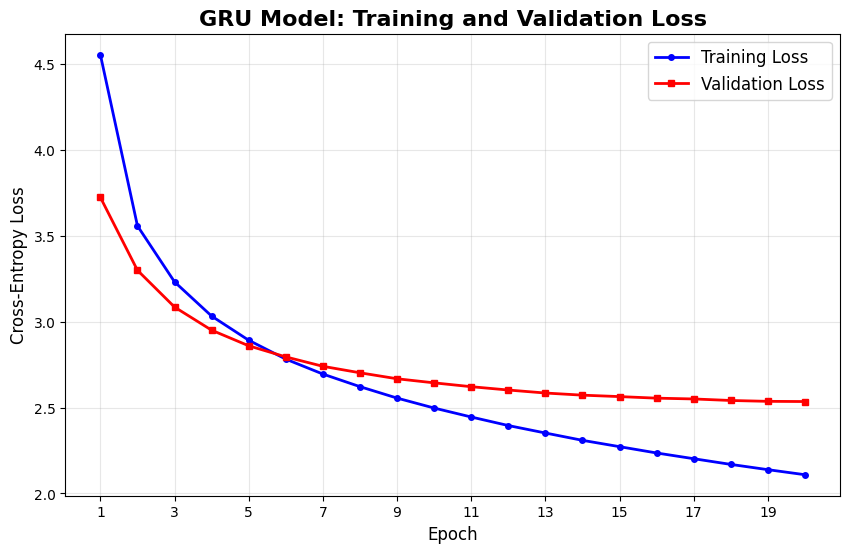

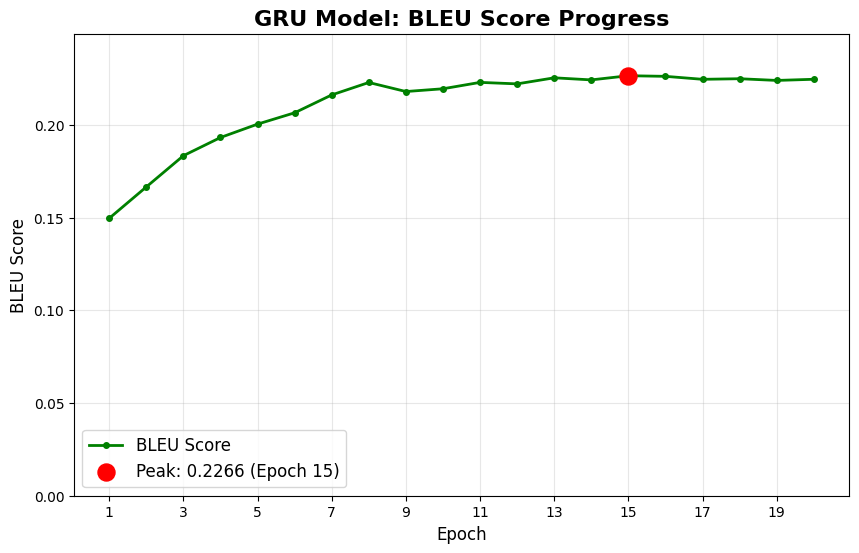

Detailed plots saved to outputs/detailed_loss_plot.png and outputs/detailed_bleu_plot.png
Training complete!


In [ ]:
import matplotlib.pyplot as plt

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Training and Validation Loss
epochs_range = range(1, len(train_losses) + 1)
ax1.plot(epochs_range, train_losses, 'b-', label='Training Loss', linewidth=2)
ax1.plot(epochs_range, val_losses, 'r-', label='Validation Loss', linewidth=2)
ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: BLEU Score vs Epoch
ax2.plot(epochs_range, bleu_scores, 'g-', label='BLEU Score', linewidth=2)
# Mark the best BLEU point
if best_bleu > 0:
    ax2.scatter([best_bleu_epoch], [best_bleu], color='red', s=100, zorder=5,
                label=f'Best BLEU: {best_bleu:.4f} at epoch {best_bleu_epoch}')
ax2.set_title('BLEU Score vs Epoch', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('BLEU Score')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('outputs/training_plots.png', dpi=300, bbox_inches='tight')
plt.savefig('outputs/training_plots.pdf', bbox_inches='tight')  # Also save as PDF
plt.close()

print("Training plots saved to outputs/training_plots.png and outputs/training_plots.pdf")

# Create individual detailed plots

# Detailed Loss Plot
plt.figure(figsize=(10, 6))
plt.plot(epochs_range, train_losses, 'b-', label='Training Loss', linewidth=2, marker='o', markersize=4)
plt.plot(epochs_range, val_losses, 'r-', label='Validation Loss', linewidth=2, marker='s', markersize=4)
plt.title('GRU Model: Training and Validation Loss', fontsize=16, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Cross-Entropy Loss', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(range(1, len(train_losses) + 1, max(1, len(train_losses)//10)))
plt.savefig('outputs/detailed_loss_plot.png', dpi=300, bbox_inches='tight')
plt.show()

# Detailed BLEU Plot
plt.figure(figsize=(10, 6))
plt.plot(epochs_range, bleu_scores, 'g-', label='BLEU Score', linewidth=2, marker='o', markersize=4)
if best_bleu > 0:
    plt.scatter([best_bleu_epoch], [best_bleu], color='red', s=150, zorder=5,
                label=f'Peak: {best_bleu:.4f} (Epoch {best_bleu_epoch})')
plt.title('GRU Model: BLEU Score Progress', fontsize=16, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('BLEU Score', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(range(1, len(bleu_scores) + 1, max(1, len(bleu_scores)//10)))
if len(bleu_scores) > 0:
    plt.ylim(0, max(bleu_scores) * 1.1)  # Set y-axis limits for better visualization
plt.savefig('outputs/detailed_bleu_plot.png', dpi=300, bbox_inches='tight')
plt.show()

print("Detailed plots saved to outputs/detailed_loss_plot.png and outputs/detailed_bleu_plot.png")

print("Training complete!")